# Social Media Sanctions and Misinformation Sharing

This notebook investigates whether social media sanctions and the sharing of low-quality news content vary based on political ideology. We aim to explore the relationship between political beliefs, misinformation sharing, and account suspensions on social media platforms, particularly Twitter.

Our analysis will focus on the likelihood of suspension for users with different political affiliations and assess the quality of news shared by these groups. We will examine various measures of news quality, including assessments by professional fact-checkers and crowdsourced participants. Furthermore, we will evaluate the potential influence of political ideology on these measures, using statistical methods to understand trends and relationships.

Finally, we will model the predictors of social media suspension, considering both single and multiple factors, to identify significant contributors to account sanctions.

We will use the data from [Mohshen Moshel et al. analysis on Nature](https://www.nature.com/articles/s41586-024-07942-8), available at [mosleh_et_al_data.csv](mosleh_et_al_data.csv).


## Setup

- This notebook requires a few Python libraries for data analysis and visualization.

- If you don’t have them installed, run the code below in the first cell of the notebook.

In [1]:
%pip install pandas numpy scipy matplotlib seaborn scikit-learn statsmodels

- As a first step, we need to import the necessary libraries.

In [2]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
from scipy.stats import chi2_contingency, zscore, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.patches as mpatches

- The [mosleh_et_al_data.csv](mosleh_et_al_data.csv) file should be at the same directory with this notebook.

- We read the file.

In [3]:
file_path = 'mosleh_et_al_data.csv'
data = pd.read_csv(file_path)

## Twitter Suspensions after the 2020 Election

- Using crosstabulation, we will show that accounts that shared `#Trump2020` during the election were about 4.4 times more likely to be subsequently suspended than the accounts that shared `#VoteBidenHarris2020`.

- First, let's check the unique values at the relevant columns.

In [4]:
print(data['politics_hashtag'].unique())
print(data['suspended'].unique())

[0 1]
[0 1]


- Data are represented as binary values.

- Let's also check for any NaN values.

In [5]:
data[['politics_hashtag', 'suspended']].isna().sum()

politics_hashtag    0
suspended           0
dtype: int64

- Apparently, the `suspended` column uses the following encoding: 0 represents `Not Suspended`, and 1 represents `Suspended`.

- In the `politics_hashtag` column, 0 represents either the `#Trump2020` or the `#VoteBidenHarris2020` hashtags.

- According to the analysis by [Mohshen Moshel et al.](https://www.nature.com/articles/s41586-024-07942-8), accounts that shared the `#Trump2020` hashtag during the election were 4.4 times more likely to have been subsequently suspended compared to those that shared the `#VoteBidenHarris2020` hashtag.

- Let's assume that 0 represents `#Trump2020` and 1 represents `#VoteBidenHarris2020` to try it out.


In [6]:
# Create crosstab
crosstab = pd.crosstab(data['politics_hashtag'], data['suspended'])

# Calculate suspension rates
trump_suspended_rate = crosstab.loc[0, 1] / crosstab.loc[1].sum()  # Assuming 0 represents #Trump2020
biden_suspended_rate = crosstab.loc[1, 1] / crosstab.loc[0].sum()  # Assuming 1 represents #VoteBidenHarris2020

likelihood_ratio = trump_suspended_rate / biden_suspended_rate

print("Assuming that 0 represents #Trump2020 and 1 represents #VoteBidenHarris2020:")
print(f"Suspension rate for #Trump2020: {trump_suspended_rate:.2f}")
print(f"Suspension rate for #VoteBidenHarris2020: {biden_suspended_rate:.2f}")
print(f"Likeliness of suspension (#Trump2020 vs #VoteBidenHarris2020): {likelihood_ratio:.2f}")

Assuming that 0 represents #Trump2020 and 1 represents #VoteBidenHarris2020:
Suspension rate for #Trump2020: 0.04
Suspension rate for #VoteBidenHarris2020: 0.20
Likeliness of suspension (#Trump2020 vs #VoteBidenHarris2020): 0.23


- It seems that 0 represents `#VoteBidenHarris2020` and 1 represents `#Trump2020`.

In [7]:
trump_suspended_rate = crosstab.loc[1, 1] / crosstab.loc[1].sum()  # Assuming 1 represents #Trump2020
biden_suspended_rate = crosstab.loc[0, 1] / crosstab.loc[0].sum()  # Assuming 0 represents #VoteBidenHarris2020

# Calculate likelihood ratio
likelihood_ratio = trump_suspended_rate / biden_suspended_rate

# Display results
print(f"Suspension rate for #Trump2020: {trump_suspended_rate:.2f}")
print(f"Suspension rate for #VoteBidenHarris2020: {biden_suspended_rate:.2f}")
print(f"Likeliness of suspension (#Trump2020 vs #VoteBidenHarris2020): {likelihood_ratio:.2f}")

Suspension rate for #Trump2020: 0.20
Suspension rate for #VoteBidenHarris2020: 0.04
Likeliness of suspension (#Trump2020 vs #VoteBidenHarris2020): 4.40


- Now, we will perform a $\chi^2$ test on the contingency table.

- It will help us assess whether the observed differences in account suspension rates across hashtags are due to chance or reflect a meaningful relationship.

In [8]:
chi2, p, dof, expected = chi2_contingency(crosstab)

print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-value: {p:.4f}")

Chi-Square Statistic: 485.47
P-value: 0.0000


- The results indicate a significant association between the `politics_hashtag` and whether an account was suspended $(P < 0.001)$.

- This supports the claim that accounts sharing `#Trump2020` were more likely to be suspended compared to those sharing `#VoteBidenHarris2020`.

## Distributions of Relative Frequency of Low Quality

- We will plot the distributions of low-quality sharing as determined by eight professional fact-checkers (column `lowqual_pr2019_fc`), and by crowdsourcing (column `lowqual_pr2019_crowd`), grouped by `politics_hashtag`.

- Let's check `lowqual_pr2019_fc` and `lowqual_pr2019_crowd` columns for NaN values.

In [9]:
print(data[['lowqual_pr2019_fc']].isna().sum())
print(data[['lowqual_pr2019_crowd']].isna().sum())

lowqual_pr2019_fc    55
dtype: int64
lowqual_pr2019_crowd    55
dtype: int64


- We drop these values.

In [10]:
data_cleaned = data.dropna(subset=['lowqual_pr2019_fc', 'lowqual_pr2019_crowd'])

- We begin by focusing on the professional fact-checkers.

- A copy of the `data_cleaned` dataframe is created to avoid triggering a `SettingWithCopyWarning`.

- The `lowqual_pr2019_fc` column is standardized using z-scores, preparing it for use on the $x$-axis.

In [11]:
data_cleaned = data_cleaned.copy()

data_cleaned.loc[:, 'lowqual_zscore'] = zscore(data_cleaned['lowqual_pr2019_fc'])

- We use **Seaborn** to create the plot.

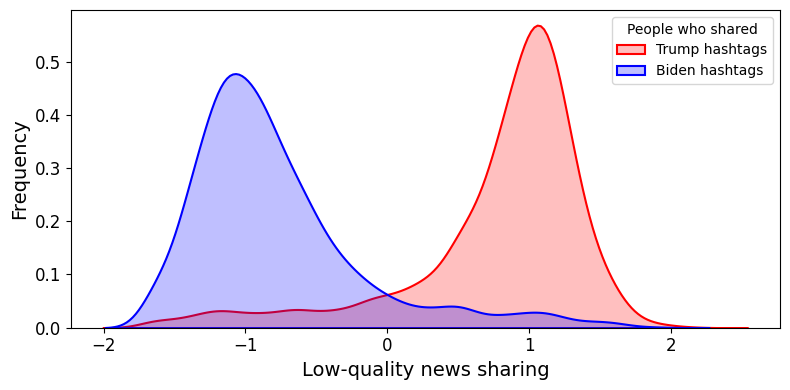

In [12]:
plt.figure(figsize=(8, 4))

sns.kdeplot(
    data=data_cleaned,
    x='lowqual_zscore',
    hue='politics_hashtag',
    fill=True,
    linewidth=1.5,
    palette={1: 'red', 0: 'blue'}
)

plt.xlabel('Low-quality news sharing', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(title='People who shared', labels=['Trump hashtags', 'Biden hashtags'])

plt.tight_layout()

- We follow the same approach for the crowdsourcing data.

- The `lowqual_pr2019_crowd` column is standardized using z-scores, preparing it for use on the $x$-axis.

In [13]:
data_cleaned.loc[:, 'lowqual_crowd_zscore'] = zscore(data_cleaned['lowqual_pr2019_crowd'])

- Again, we use **Seaborn** for the plot.

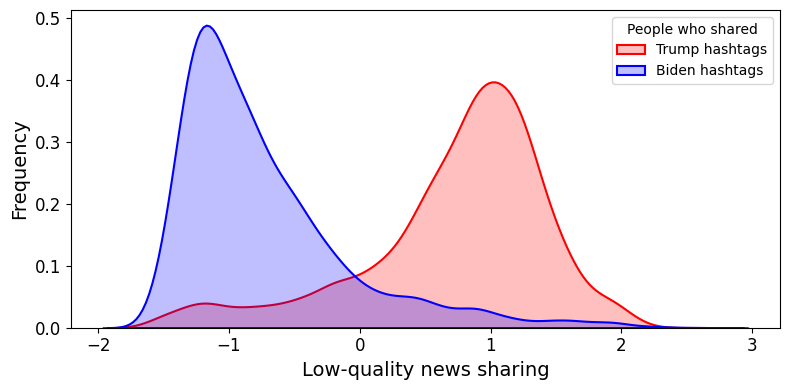

In [14]:
plt.figure(figsize=(8, 4))

sns.kdeplot(
    data=data_cleaned,
    x='lowqual_crowd_zscore',
    hue='politics_hashtag',
    fill=True,
    linewidth=1.5,
    palette={1: 'red', 0: 'blue'}
)

plt.xlabel('Low-quality news sharing', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(title='People who shared', labels=['Trump hashtags', 'Biden hashtags'])

plt.tight_layout()

- Both plots show that individuals who used the Trump-related hashtag shared lower-quality news compared to those who used the Biden-related hashtag.

## Low-quality News Sharing on Twitter

- We will proceed to examine low-quality news sharing on Twitter in a more quantitative manner, using the t-test.

- The effect size of the t-test will be quantified using Cohen's $d$ and Hedges' $g$.

- We will focus on the following columns.

In [15]:
columns_quality = [
    'lowqual_pr2019_fc',
    'lowqual_lasser2019',
    'lowqual_mbfc',
    'lowqual_afm',
    'lowqual_pr2019_crowd',
    'lowqual_pr2019_crowdrep'
]

- Let's take a look at their values.

In [16]:
for column in columns_quality:
    print(data[column].unique())

[0.27922076 0.84863949 0.24234694 ... 0.72091836 0.40022677 0.80877978]
[0.35000002 0.9750874  0.30000001 ... 0.33675802 0.77232146 0.35521233]
[0.29280674 0.51314735 0.24244547 ... 0.56883162 0.3038975  0.2848618 ]
[0.18531549 0.61415553 0.13094997 ... 0.21791524 0.38863212 0.18515611]
[0.59888339 0.77487338 0.54872704 ... 0.62764817 0.76455134 0.58181894]
[0.70080042 0.75511819 0.65811777 ... 0.71413273 0.73244727 0.68608385]


- We also check for NaNs.

- The NaN values will be addressed and removed in a subsequent step.

In [17]:
for column in columns_quality:
    print(data[column].isna().sum())

55
1
1
2
55
55


- We will define two functions for the Cohen's $d$ and Hedges' $g$.

In [18]:
def cohen_d(group1, group2):
    mean1, mean2 = np.mean(group1), np.mean(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    n1, n2 = len(group1), len(group2)
    
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    return abs(mean1 - mean2) / pooled_std # We use the absolute value to avoid negative values

def hedges_g(group1, group2):
    d = cohen_d(group1, group2)
    n1, n2 = len(group1), len(group2)
    correction = 1 - (3 / (4 * (n1 + n2) - 9))
    
    return d * correction


- Let's perform the analysis for each column.

In [19]:
for column in columns_quality:
    print(f"Analyzing: {column}")
    
    # Drop NaN values for the current column
    data_cleaned = data.dropna(subset=[column])
    
    # Split the data into the two groups
    group_trump = data_cleaned[data_cleaned['politics_hashtag'] == 1][column]
    group_biden = data_cleaned[data_cleaned['politics_hashtag'] == 0][column]
    
    # Perform t-test
    t_stat, p_value = ttest_ind(group_trump, group_biden, nan_policy='omit')
    
    # Calculate effect sizes
    d = cohen_d(group_trump, group_biden)
    g = hedges_g(group_trump, group_biden)
    
    print(f"T-statistic: {t_stat:.3f}")
    print(f"P-value: {p_value:.3e}")
    print(f"Cohen's d: {d:.3f}")
    print(f"Hedges' g: {g:.3f}")
    
    # Determine effect size category
    if d < 0.20:
        effect_size = "Very small"
    elif d < 0.50:
        effect_size = "Small"
    elif d < 0.80:
        effect_size = "Medium"
    elif d < 1.20:
        effect_size = "Large"
    elif d < 2.00:
        effect_size = "Very Large"
    else:
        effect_size = "Huge"
    
    print(f"Effect size: {effect_size}")
    print("-" * 50)

Analyzing: lowqual_pr2019_fc
T-statistic: 119.223
P-value: 0.000e+00
Cohen's d: 2.521
Hedges' g: 2.521
Effect size: Huge
--------------------------------------------------
Analyzing: lowqual_lasser2019
T-statistic: 102.634
P-value: 0.000e+00
Cohen's d: 2.164
Hedges' g: 2.164
Effect size: Huge
--------------------------------------------------
Analyzing: lowqual_mbfc
T-statistic: 97.592
P-value: 0.000e+00
Cohen's d: 2.058
Hedges' g: 2.057
Effect size: Huge
--------------------------------------------------
Analyzing: lowqual_afm
T-statistic: 102.678
P-value: 0.000e+00
Cohen's d: 2.165
Hedges' g: 2.165
Effect size: Huge
--------------------------------------------------
Analyzing: lowqual_pr2019_crowd
T-statistic: 102.464
P-value: 0.000e+00
Cohen's d: 2.167
Hedges' g: 2.167
Effect size: Huge
--------------------------------------------------
Analyzing: lowqual_pr2019_crowdrep
T-statistic: 61.071
P-value: 0.000e+00
Cohen's d: 1.291
Hedges' g: 1.291
Effect size: Very Large
----------------

- The t-tests across all variables related to low-quality news sharing reveal highly significant differences (p-values = 0.000).

- The effect sizes are consistently large.

- The lowest effect size observed was **1.291** for `lowqual_pr2019_crowdrep`, groups of only Republican laypeople, which still qualifies as a **very large** effect size.

- Overall, all analyzed variables exhibit substantial differences in low-quality news sharing, suggesting a strong presence of these factors in the data.

- It looks like political affiliation plays a significant role in the sharing of low-quality news on Twitter.

### Sharing Lower-quality News Sources and Conservative Ideology

- We aim to determine whether there is a correlation between lower-quality news sources and conservative ideology.

- The ideology-related columns will be defined.

In [20]:
columns_politics = [
    'politics_followed',
    'politics_hashtag',
    'politics_sites1',
    'politics_sites2'
]

for column in columns_politics:
    print(data[column].unique())

[-0.08029453  2.296375   -2.3127301  ...  1.6893206   1.5254937
 -1.4118648 ]
[0 1]
[-1.168745    1.060905   -0.500076   ... -0.92560548  0.92505997
 -0.77351648]
[-0.23190165  0.40526086 -0.17106667 ... -0.21456853  0.42492682
 -0.16868182]


- We perform the pairwise correlations.

In [21]:
correlation_matrix = data[columns_quality + columns_politics].corr()

correlations_subset = correlation_matrix.loc[columns_quality, columns_politics]

- We display the results in a heatmap.

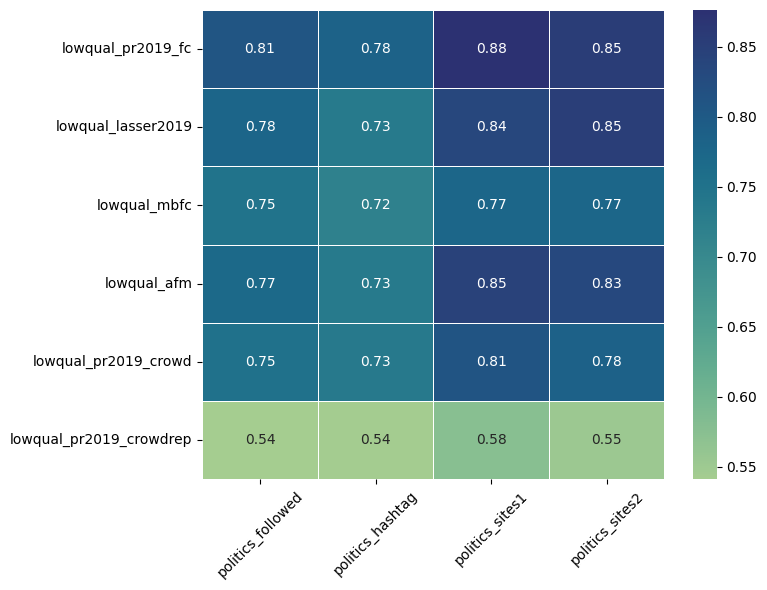

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlations_subset,
    annot=True, 
    fmt=".2f", 
    cmap="crest",
    linewidths=0.5
)

plt.xticks(rotation=45)
plt.tight_layout()

- The heatmap shows a strong positive correlation between lower-quality news sources and conservative ideology.

- Even when using trustworthiness ratings from Republican sources (`lowqual_pr2019_crowdrep`), a moderate correlation is observed.

## News Sharing Can Help Explain Suspension, Using Single Predictors

- We want to predict whether a user was suspended or not.

- For predictors, we are going to use the columns related to the political orientation of the user and the low-quality news sharing ratings.

- Let's see the available data.

In [23]:
predictors = [
    'politics_hashtag', 'politics_sites1', 'politics_sites2', 
    'politics_followed', 'lowqual_afm', 'lowqual_mbfc', 
    'lowqual_lasser2019', 'lowqual_pr2019_fc', 'lowqual_pr2019_crowd'
]

for predictor in predictors:
    print(data[predictor].unique())

[0 1]
[-1.168745    1.060905   -0.500076   ... -0.92560548  0.92505997
 -0.77351648]
[-0.23190165  0.40526086 -0.17106667 ... -0.21456853  0.42492682
 -0.16868182]
[-0.08029453  2.296375   -2.3127301  ...  1.6893206   1.5254937
 -1.4118648 ]
[0.18531549 0.61415553 0.13094997 ... 0.21791524 0.38863212 0.18515611]
[0.29280674 0.51314735 0.24244547 ... 0.56883162 0.3038975  0.2848618 ]
[0.35000002 0.9750874  0.30000001 ... 0.33675802 0.77232146 0.35521233]
[0.27922076 0.84863949 0.24234694 ... 0.72091836 0.40022677 0.80877978]
[0.59888339 0.77487338 0.54872704 ... 0.62764817 0.76455134 0.58181894]


- We check for NaNs.

- The NaN values will be addressed and removed in a subsequent step.

In [24]:
target = 'suspended'

for col in predictors:
    print(f"{col}: NaNs -> {data[col].isnull().sum()}, Unique values -> {data[col].nunique()}")

politics_hashtag: NaNs -> 0, Unique values -> 2
politics_sites1: NaNs -> 0, Unique values -> 8961
politics_sites2: NaNs -> 0, Unique values -> 8822
politics_followed: NaNs -> 1035, Unique values -> 7962
lowqual_afm: NaNs -> 2, Unique values -> 8930
lowqual_mbfc: NaNs -> 1, Unique values -> 8353
lowqual_lasser2019: NaNs -> 1, Unique values -> 4760
lowqual_pr2019_fc: NaNs -> 55, Unique values -> 4906
lowqual_pr2019_crowd: NaNs -> 55, Unique values -> 7975


- Continuing, we want to apply the **probit** model for the predictions.

- The predictions will be evaluated with the AUC of the ROC curve.

- To get confidence intervals, we repeat each prediction 100 times by using the boostrap method.

In [25]:
results = []
n_bootstrap = 100

for predictor in predictors:
    
    # Drop NaN values for the current predictor
    data_cleaned = data[[predictor, target]].dropna()
    
    # Split into training and testing sets
    X = data_cleaned[predictor]
    y = data_cleaned[target]
    
    # Fit the model
    formula = f"{target} ~ {predictor}"

    model = smf.probit(formula=formula, data=data_cleaned).fit(disp=0)
    data_cleaned['pred_prob'] = model.predict(X)

    auc_results = []

    # Perform bootstrap method
    for _ in range(n_bootstrap):
        bootstraped_data = data_cleaned.sample(frac=1, replace=True)
        auc = roc_auc_score(bootstraped_data[target], bootstraped_data['pred_prob'])
        auc_results.append(auc)

    # Calculate mean and confidence intervals
    mean_auc = np.mean(auc_results)
    lower_bound = np.percentile(auc_results, 2.5)
    upper_bound = np.percentile(auc_results, 97.5)

    results.append({
        "Predictor": predictor,
        "AUC": mean_auc,
        "CI Lower": lower_bound,
        "CI Upper": upper_bound
    })

results_df = pd.DataFrame(results)

results_df

,Predictor,AUC,CI Lower,CI Upper
0,politics_hashtag,0.678304,0.667409,0.691671
1,politics_sites1,0.700262,0.688011,0.713061
2,politics_sites2,0.705124,0.690016,0.719034
3,politics_followed,0.717885,0.702405,0.734238
4,lowqual_afm,0.716187,0.702685,0.732253
5,lowqual_mbfc,0.707455,0.691251,0.721788
6,lowqual_lasser2019,0.706817,0.690716,0.724676
7,lowqual_pr2019_fc,0.697851,0.684604,0.711498
8,lowqual_pr2019_crowd,0.686402,0.671769,0.701937


- We will plot all our evaluations and the confidence intervals in a barchart.

- First, we split the predictors to `political` and `lowqual` for Political orientation and Low-quality news sharing correspondingly.

In [26]:
political_predictors = [
    'politics_hashtag', 'politics_sites1', 'politics_sites2', 'politics_followed'
]
lowqual_predictors = [
    'lowqual_afm', 'lowqual_mbfc', 'lowqual_lasser2019', 'lowqual_pr2019_fc', 'lowqual_pr2019_crowd'
]

- We also define the descriptions for the x-axis using a dictionary.

In [27]:
descriptions = {
    'politics_hashtag': 'Hashtag\nShared',
    'politics_sites1': 'News\nSites\nShared 1',
    'politics_sites2': 'News\nSites\nShared 2',
    'politics_followed': 'Accounts\nFollowed',
    'lowqual_afm': 'AFM\nRatings',
    'lowqual_mbfc': 'MBFC\nRatings',
    'lowqual_lasser2019': 'Lasser\nRatings',
    'lowqual_pr2019_fc': 'Fact-\nChecker\nRatings',
    'lowqual_pr2019_crowd': 'Layperson\nRatings'
}

- Now let's plot the barchart.

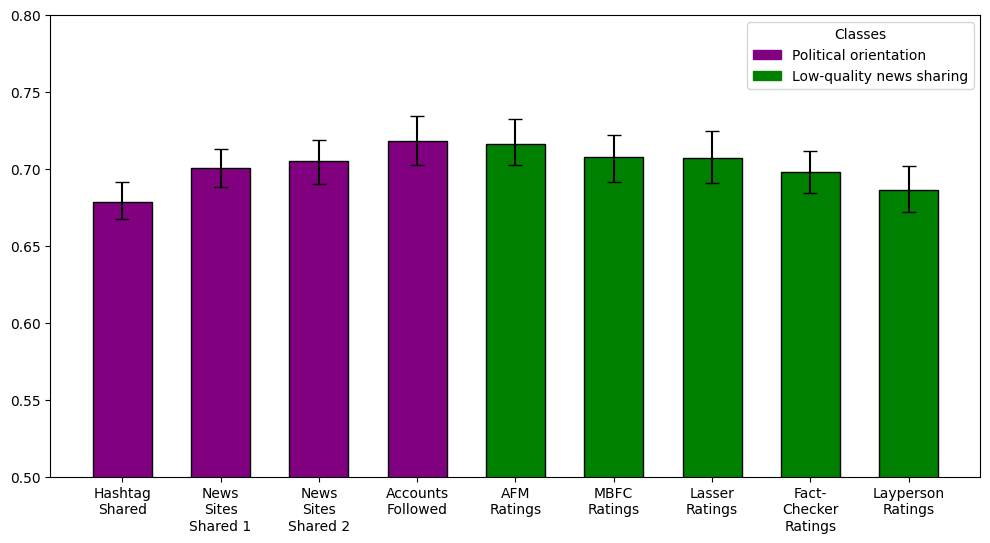

In [28]:
# Add descriptions to the results dataframe for plotting
results_df['Description'] = results_df['Predictor'].map(descriptions)

plt.figure(figsize=(12, 6))

colors = []

# Assign colors to political and low-quality predictors
for predictor in results_df['Predictor']:
    if predictor in political_predictors:
        colors.append('purple')
    elif predictor in lowqual_predictors:
        colors.append('green')
    else:
        colors.append('gray')  # Default color if needed

plt.bar(results_df['Description'], results_df['AUC'], 
        yerr=[results_df['AUC'] - results_df['CI Lower'], 
              results_df['CI Upper'] - results_df['AUC']], 
        capsize=5, color=colors, width=0.6, edgecolor='black')

plt.xticks(fontsize=10, ha='center')

# Set y-axis range from 0.5 to 0.8
plt.ylim(0.5, 0.8)

political_patch = mpatches.Patch(color='purple', label='Political orientation')
lowqual_patch = mpatches.Patch(color='green', label='Low-quality news sharing')
plt.legend(title='Classes', handles=[political_patch, lowqual_patch])

plt.show()


- The results show that all predictors have a relatively strong ability to predict user suspension.

-  Political orientation and sharing low-quality news are similarly predictive of suspension

## News Sharing Can Help Explain Suspension, Using Multiple Predictors

- We will also use multiple regression models to predict and explain suspension.

- We start by filing in missing values in our data by using the column mean.

In [29]:
data.fillna(data.mean(), inplace=True)

- Then, we log transform, base 10, the variables that are related to Twitter metrics.

- We add 1 to prevent $log(0)$.

In [30]:
data['log_repeated_tweet_count'] = np.log10(data['repeated_tweet_count'] + 1)
data['log_freq_pr_1h'] = np.log10(data['freq_pr_1h'] + 1)
data['log_num_followers'] = np.log10(data['num_followers'] + 1)
data['log_num_friends'] = np.log10(data['num_friends'] + 1)

- We introduce an additional variable, `log_fol`, which is the base 10 logarithm of `num_friends` over `num_followers` ratio.

In [31]:
data['log_fol'] = np.log10((data['num_friends'] + 1) / (data['num_followers'] + 1))

- To reduce the effect of outliers, we will [winsorize](https://en.wikipedia.org/wiki/Winsorizing) the data of the following columns.

In [32]:
columns_to_winsorize = [
    'valence_neg', 'valence_neu', 'valence_pos', 
    'barbera_std', 'politics_sites1_std', 'politics_sites2_ideo_std'
]

- We winzorize from both sides at the top 1%.

In [33]:
for col in columns_to_winsorize:
    data[col] = winsorize(data[col], limits=(0.01, 0.01))

- We will winsorize the upper side of the following  variables at the top 1%.

In [34]:
columns_to_winsorize_upper = [
    'moral_outrage', 'rewire_abuse', 'rewire_hate', 
    'rewire_profanity', 'rewire_violent', 'rewire_sexually_explicit',
    'jigsaw_toxicity', 'jigsaw_severe_toxicity', 'jigsaw_idenity_attack', 
    'jigsaw_insult', 'jigsaw_profanity', 'jigsaw_threat'
]

for col in columns_to_winsorize_upper:
    data[col] = winsorize(data[col], limits=(0, 0.01))

- We will derive and use a single PCA component, `pc1_misinfo`, for low quality news sharing.

- PCA helps simplify things by combining all the related measures of low-quality news sharing into one key summary measure (`pc1_misinfo`), so we can focus on the bigger picture without losing important information.

- Let's start by defining the low quality related columns.

In [35]:
lowqual_columns = [
    'lowqual_pr2019_fc', 'lowqual_afm', 'lowqual_lasser2019', 'lowqual_mbfc'
]

- As PCA works with the variance in order to identify the new dimensions, it requires data normalisation.

- We standardize the selected variables to ensure they have a mean of 0 and a standard deviation of 1.

In [36]:
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data[lowqual_columns])

# Print the mean and standard deviation of the standardized data, rounded to the nearest integer
print("Mean =", np.mean(data_standardized, axis=0).round(), "Std Dev =", np.std(data_standardized, axis=0).round())

Mean = [ 0. -0. -0. -0.] Std Dev = [1. 1. 1. 1.]


- The variables have a mean very close to 0 and a standard deviation of 1, confirming successful standardization to a unit-normal scale.

- We perform PCA.

In [37]:
pca = PCA(n_components=1)  # We're interested in just the first component
pc1 = pca.fit_transform(data_standardized)

- We show the explained variance ratio, which tells us how much of the variation in low-quality news sharing is captured by our single PCA component.

- We project the low quality news sharing dimensions to this new dimension, by creating a new column for `pc1_misinfo`.

In [38]:
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio for PC1:", explained_variance_ratio)

data['pc1_misinfo'] = pc1

Explained Variance Ratio for PC1: [0.87255953]


- As we can see, the explained variance ratio for `pc1_misinfo` is **0.8726**, meaning that **87.26%** of the variation in the low-quality news sharing variables is captured by this single principal component. 

- This indicates that `pc1_misinfo` is highly representative of the combined patterns in these variables, making it a strong summary measure.

- We will work in the same way for the political orientation, getting a single PCA component, `pc1_politics`.

- Again, we start by standardizing.

In [39]:
political_columns = ['politics_hashtag', 'politics_followed', 'politics_sites1', 'politics_sites2']

data_politics_standardized = data.copy()

scaler_politics = StandardScaler()
data_politics_standardized[political_columns] = scaler_politics.fit_transform(data_politics_standardized[political_columns])

- We perform PCA.

In [40]:
pca_politics = PCA(n_components=1)  # We only want the first principal component

pc1_politics = pca_politics.fit_transform(data_politics_standardized[political_columns])

data['pc1_politics'] = pc1_politics

# Calculate the explained variance ratio
explained_variance_ratio_politics = pca_politics.explained_variance_ratio_
print("Explained Variance Ratio for Political Orientation PCA:", explained_variance_ratio_politics)

Explained Variance Ratio for Political Orientation PCA: [0.87952937]


- Again, the explained variance ratio for the political orientation PCA is high, meaning the single component effectively summarizes the majority of variation in the political orientation variables.

- We will introduce a new variable, `extremity`, which is the absolute value of the PCA component we got.

In [41]:
data['extremity'] = abs(data['pc1_politics'])

- We also do the same for `log_followers`, `log_friends`, `log_fol`, producing `pc1_fol`.

In [42]:
social_columns = ['log_num_followers', 'log_num_friends', 'log_fol']

data_social_standardized = data.copy()

# Standardize the social network variables
scaler_social = StandardScaler()
data_social_standardized[social_columns] = scaler_social.fit_transform(data_social_standardized[social_columns])

# Apply PCA to the social network metrics
pca_social = PCA(n_components=1)  # We only want the first principal component

# Fit the PCA model
pc1_fol = pca_social.fit_transform(data_social_standardized[social_columns])

data['pc1_fol'] = pc1_fol

# Calculate the explained variance ratio
explained_variance_ratio_social = pca_social.explained_variance_ratio_
print("Explained Variance Ratio for Social Network PCA:", explained_variance_ratio_social)

# Create the extremity variable as the absolute value of the social network component
data['extremity_fol'] = abs(data['pc1_fol'])

Explained Variance Ratio for Social Network PCA: [0.70462969]


- The single component captures a substantial portion of the variability in the social network-related variables, though not as comprehensively as in the previous cases.

- Regarding the harmful language variables, we'll perform PCA for *three* components, `pc1_harmful_language`, `pc2_harmful_language`, `pc3_harmful_language`.

In [43]:
harmful_language_columns = [
    'rewire_abuse', 'rewire_hate', 'rewire_profanity', 'rewire_violent',
    'rewire_sexually_explicit', 'jigsaw_toxicity', 'jigsaw_severe_toxicity',
    'jigsaw_idenity_attack', 'jigsaw_insult', 'jigsaw_profanity', 'jigsaw_threat'
]

data_harmful_language_standardized = data.copy()

# Standardize the harmful language variables
scaler_harmful = StandardScaler()
data_harmful_language_standardized[harmful_language_columns] = scaler_harmful.fit_transform(data_harmful_language_standardized[harmful_language_columns])

# Perform PCA for three components on the harmful language variables
pca_harmful = PCA(n_components=3)

harmful_language_pca = pca_harmful.fit_transform(data_harmful_language_standardized[harmful_language_columns])

data['pc1_harmful_language'] = harmful_language_pca[:, 0]
data['pc2_harmful_language'] = harmful_language_pca[:, 1]
data['pc3_harmful_language'] = harmful_language_pca[:, 2]

explained_variance_ratio_harmful = pca_harmful.explained_variance_ratio_
total_explained_variance_ratio_harmful = explained_variance_ratio_harmful.sum()

print("Explained Variance Ratio for Harmful Language PCA (3 components):", explained_variance_ratio_harmful)

Explained Variance Ratio for Harmful Language PCA (3 components): [0.5616608  0.11871792 0.10703707]


- As we can see, the explained variance ratio for the first component is **56.17%**, which is not sufficient to represent the full complexity of the data. 

- The second and third components, while contributing smaller portions of variance (**11.87%** and **10.70%**, respectively), capture additional meaningful dimensions of variability.

In [44]:
print("Total Explained Variance Ratio for Harmful Language PCA:", total_explained_variance_ratio_harmful)

Total Explained Variance Ratio for Harmful Language PCA: 0.7874157847381196


- The total explained variance increased to 78.74%, offering a more comprehensive view.

- We will try to interpret each of the principal components.

- Let's see the components themselves.

In [45]:
pca_harmful.components_

array([[ 0.32530845,  0.23538337,  0.25255674,  0.23252186,  0.12526899,
         0.38547179,  0.33586086,  0.30692208,  0.37440778,  0.3617071 ,
         0.28039267],
       [ 0.34409751,  0.5765375 , -0.23191386,  0.06740265, -0.53686584,
         0.13232154, -0.30099609, -0.04947252,  0.13741195, -0.20511297,
        -0.17646751],
       [-0.30773448, -0.03195551, -0.43039704, -0.03699539, -0.37270948,
        -0.07810217,  0.24571418,  0.46254153, -0.03715369, -0.15336206,
         0.52291043]])

- The first component (PC1) is:

$$
z_1 = 0.32530708 \times x_1 +  0.23538239 \times x_2 + 0.25255626 \times x_3 + 0.23252051 \times x_4 + \\
0.12526832 \times x_5 + 0.38547328 \times x_6 + 0.33585696 \times x_7 + 0.30692378 \times x_8 + \\
0.3744104 \times x_9 + 0.36170918 \times x_{10} + 0.28039151 \times x_{11}
$$

- Where:
    - $x_1$ = `rewire_abuse`
    - $x_2$ = `rewire_hate`
    - $x_3$ = `rewire_profanity`
    - $x_4$ = `rewire_violent`
    - $x_5$ = `rewire_sexually_explicit`
    - $x_6$ = `jigsaw_toxicity`
    - $x_7$ = `jigsaw_severe_toxicity`
    - $x_8$ = `jigsaw_idenity_attack`
    - $x_9$ = `jigsaw_insult`
    - $x_{10}$ = `jigsaw_profanity`
    - $x_{11}$ = `jigsaw_threat`

- **PC1** captures a general dimension of harmful language, reflecting overall toxic content on Twitter.

- The second component (PC2) is:

$$
z_2 = 0.3442136 \times x_1 +  0.57654798 \times x_2 + -0.23174985 \times x_3 +  0.06743299 \times + \\
x_4 + -0.53672038 \times x_5 +  0.13235282 \times x_6 + -0.30109329 \times x_7 + -0.04965428 \times x_8 +  0.13742415 + \\
\times x_9 + -0.20505254 \times x_{10} + -0.1766735 \times x_{11}
$$

- **PC2** captures hostility and abuse, with strong influences from hate speech and aggressive language, but not from sexually explicit or general toxicity.

- The third component (PC3) is:

$$
z_3 = -0.30759356 \times x_1 + -0.03173062 \times x_2 + -0.43048054 \times x_3 + -0.03702487 \times + \\
x_4 + -0.37293747 \times x_5 + -0.07804893 \times x_6 +  0.24563426 \times x_7 +  0.46251261 \times + \\
x_8 + -0.03708868 \times x_9 + -0.15343852 \times x_{10} +  0.52282692 \times x_{11}
$$

- **PC3** captures harmful language related to identity attacks, threats, and toxicity, but not hate speech or abuse, offering a more specific dimension of harm.

- Overall, using three components instead of one allows us to capture different dimensions of harmful language.

- Each component highlights a unique aspect of harmful content.


- We return to producing a single PCA component, `pc1_valence`.

In [46]:
valence_columns = ['valence_neg', 'valence_neu', 'valence_pos']

# Standardize the data
scaler = StandardScaler()
data_standardized_valence = scaler.fit_transform(data[valence_columns])

# Apply PCA
pca_valence = PCA(n_components=1)

pc1_valence = pca_valence.fit_transform(data_standardized_valence)

data['pc1_valence'] = pc1_valence

explained_variance_ratio_valence = pca_valence.explained_variance_ratio_

print("Explained Variance Ratio for PC1 (valence):", explained_variance_ratio_valence)

Explained Variance Ratio for PC1 (valence): [0.7079432]


- Before proceeding, we normalize the independent variables by taking their z-scores.

In [47]:
independent_vars = [
    'pc1_politics', 'pc1_misinfo', 'pc1_fol', 'pc1_harmful_language', 
    'pc2_harmful_language', 'pc3_harmful_language', 'pc1_valence', 
    'tweets_in_2wk', 'botsentinel_score', 'extremity', 'moral_outrage', 
    'liwc_political', 'log_freq_pr_1h', 'log_repeated_tweet_count', 
    'barbera_std', 'politics_sites1_std', 'politics_sites2_ideo_std'
]

for var in independent_vars:
    data[var] = zscore(data[var])

- We will carry out a probit regression to predict suspension.

In [48]:
# Define the predictors and target variable
X = data[independent_vars]
y = data[target]

# Add a constant to the predictors
X = sm.add_constant(X)

probit_model = sm.Probit(y, X).fit()

p_values = probit_model.pvalues

# Summarize the model
probit_model.summary()

Optimization terminated successfully.


         Current function value: 0.302637
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              suspended   No. Observations:                 9000
Model:                         Probit   Df Residuals:                     8982
Method:                           MLE   Df Model:                           17
Date:                Sat, 07 Dec 2024   Pseudo R-squ.:                  0.1762
Time:                        18:05:08   Log-Likelihood:                -2723.7
converged:                       True   LL-Null:                       -3306.3
Covariance Type:            nonrobust   LLR p-value:                3.877e-237
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.4273      0.023    -61.086      0.000      -1.473      -1.381
pc1_politics                 0.1341      0.053      2.535      0.011       0.030       0.238
pc1_misinfo                  0.2448      0.046      5.265      0.000       0.154       0.336
pc1_fol                      0.0013      0.021      0.064      0.949      -0.040       0.042
pc1_harmful_language         0.1761      0.026      6.750      0.000       0.125       0.227
pc2_harmful_language        -0.0830      0.026     -3.226      0.001      -0.133      -0.033
pc3_harmful_language        -0.0662      0.021     -3.216      0.001      -0.107      -0.026
pc1_valence                  0.0410      0.023      1.819      0.069      -0.003       0.085
tweets_in_2wk                0.3316      0.021     15.934      0.000       0.291       0.372
botsentinel_score            0.1825      0.039      4.724      0.000       0.107       0.258
extremity                   -0.1199      0.023     -5.295      0.000      -0.164      -0.076
moral_outrage                0.0170      0.034      0.501      0.616      -0.049       0.083
liwc_political              -0.0226      0.029     -0.790      0.429      -0.079       0.033
log_freq_pr_1h               0.1222      0.023      5.351      0.000       0.077       0.167
log_repeated_tweet_count    -0.0074      0.023     -0.326      0.745      -0.052       0.037
barbera_std                 -0.0303      0.024     -1.276      0.202      -0.077       0.016
politics_sites1_std         -0.0259      0.021     -1.224      0.221      -0.067       0.016
politics_sites2_ideo_std     0.0612      0.022      2.752      0.006       0.018       0.105
============================================================================================
"""

- Before going on to interpret our results, we perform the [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) and the [Holm-Bonferroni correction](https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method) correction.

- The purpose of both of these tests is to reduce the likelihood of false positives (Type I errors) when conducting multiple statistical tests.

In [49]:
# Bonferroni correction
_, bonferroni_corrected_p, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Holm-Bonferroni correction
_, holm_bonferroni_corrected_p, _, _ = multipletests(p_values, alpha=0.05, method='holm')

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'P-value': p_values,
    'Bonferroni Corrected P-value': bonferroni_corrected_p,
    'Holm-Bonferroni Corrected P-value': holm_bonferroni_corrected_p
})

results_df = results_df.round(6) # Round to 6 decimal places

results_df

,P-value,Bonferroni Corrected P-value,Holm-Bonferroni Corrected P-value
const,0.000000,0.000000,0.000000
pc1_politics,0.011240,0.202314,0.089917
pc1_misinfo,0.000000,0.000003,0.000002
pc1_fol,0.948738,1.000000,1.000000
pc1_harmful_language,0.000000,0.000000,0.000000
pc2_harmful_language,0.001254,0.022574,0.013795
pc3_harmful_language,0.001298,0.023372,0.013795
pc1_valence,0.068850,1.000000,0.481949
tweets_in_2wk,0.000000,0.000000,0.000000
botsentinel_score,0.000002,0.000042,0.000028


- The results indicate that some factors, such as **tweets in 2 weeks**, **harmful language (PC1)**, **misinformation (PC1)**, and **extremity**, are significant predictors of suspension even after multiple testing corrections.

- Based on the results, the P-value for `pc1_politics` (the principal component representing political orientation) is significant before correction $(p = 0.0112)$ but becomes non-significant after both Bonferroni and Holm-Bonferroni corrections (adjusted $p > 0.05$). 

- This suggests that while there is a weak association between political orientation and suspension in the uncorrected results, this relationship does not hold under stricter multiple testing controls.

- Therefore, **political orientation is not a strong or reliable predictor of suspension** in this analysis.

- Suspension is primarily influenced by behavioral and harmful content metrics rather than political orientation or emotional valence.

- We'll do the same analysis using logit regression.

In [50]:
# Define the predictors and target variable
X = data[independent_vars]
y = data[target]

# Add a constant to the predictors
X = sm.add_constant(X)

logit_model = sm.Logit(y, X).fit()

p_values_logit = logit_model.pvalues

# Perform Bonferroni correction
_, bonferroni_corrected_p_logit, _, _ = multipletests(p_values_logit, alpha=0.05, method='bonferroni')

# Perform Holm-Bonferroni correction
_, holm_bonferroni_corrected_p_logit, _, _ = multipletests(p_values_logit, alpha=0.05, method='holm')

# Create a DataFrame to display the results
results_df_logit = pd.DataFrame({
    'P-value': p_values_logit,
    'Bonferroni Corrected P-value': bonferroni_corrected_p_logit,
    'Holm-Bonferroni Corrected P-value': holm_bonferroni_corrected_p_logit
})

# Round the numbers for better readability
results_df_logit = results_df_logit.round(6) # Round to 6 decimal places

results_df_logit

Optimization terminated successfully.
         Current function value: 0.303039
         Iterations 7


,P-value,Bonferroni Corrected P-value,Holm-Bonferroni Corrected P-value
const,0.000000,0.000000,0.000000
pc1_politics,0.007369,0.132651,0.066325
pc1_misinfo,0.000000,0.000001,0.000001
pc1_fol,0.960239,1.000000,1.000000
pc1_harmful_language,0.000000,0.000000,0.000000
pc2_harmful_language,0.001648,0.029664,0.017252
pc3_harmful_language,0.001568,0.028230,0.017252
pc1_valence,0.089166,1.000000,0.624161
tweets_in_2wk,0.000000,0.000000,0.000000
botsentinel_score,0.000001,0.000013,0.000009


- The results of the logit regression are broadly consistent with those of the probit regression.

- Both methods affirm the primary importance of harmful content and behavioral metrics over political orientation in predicting suspension.